Dustin Burnham,   Astro 499,   6/9/16

Differential Chromatic Refraction (DCR) is the wavelength dependence of atmospheric refraction, and this notebook will explore how redshifting Seds can change their DCR.  The larger the airmass value the larger the DCR we measure.  We can use this DCR to "break degeneracies in photometric redshift estimates of quasars with correct photometric redshifts" according to the paper "Astrometric Redshifts for Quasars" written by Michael C. Kaczmarczik, Gordon T. Richards, Sajjan S. Mehta, and David J. Schlegel.  We can start by importing classes from the lsst.sims.photUtils, and then we import the sample Sed of the quasar.  The bandpass of this Sed can be measured using testBandpassDict, giving the magnitude of the quasar in u,g,r,i,z, and y.  The DCR class is depentent on an atmospheric function that takes into account the wavelength, temperature, water vapor pressure, and pressure.  The centroid shift R can be calculated as a function of of bandpass and zenith distance (in radians).  We will want to start by making a DCR that will be our original, and other redshifted DCRs for comparison.  We can do this by reading in our dcr, then making deep copies.  These copies can be redshifted to specific redshifts by treating the test DCRs as Seds and using the task redshiftSed(Z), where Z is our redshift.  Once redshifted we can use them and the calcR_DCR from the DCR class to calculate the DCR at redshifts of 0 to 4 in incriments of 0.5.  The difference between each are very small but become noticeable when subtracting values.  The first graph used shows the total DCR at these various redshifts, and the second graph shows the g-r (red) and the u-r (black).  The original data was offset about 0.42 for g-r, and 0.75 for u-r, so I subtraced these off to get a clearer look at how these functions oscillate.  We can take these subtracted values and compare them to the g-r and u-r of another quasar presented in the same paper above.  The third graph is the g-r and u-r of the comparison quasar.  Comparing the two graphs we can see that the peeks and valleys are very similar.  Any variance could be a result of the fact that we are measuring two different quasars.  The fact that the peeks and valleys are consistent means that the process used to calculate the DCR is a good one, and can be used other with quasars.   The final graph is the overall positional offset at the angle of 45 degrees.  This process can be made more efficient by using a for loop to determine the DCR, compared to calculating 8 seperate ones as I did.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from lsst.sims.photUtils.Sed import Sed
from lsst.sims.photUtils.BandpassDict import BandpassDict
from lsst.utils import getPackageDir
import scipy.integrate as integrate
import scipy.interpolate as interp
from copy import deepcopy
from IPython.display import Image

%matplotlib inline

In [2]:
origSed = Sed()
#Make an original

In [3]:
origSed.readSED_flambda(str(getPackageDir('sims_sed_library') + '/agnSED/agn.spec.gz'))
#Read in the SED from the LSST database

In [4]:
testBandpassDict = BandpassDict.loadTotalBandpassesFromFiles()
#Read in the Bandpass

In [5]:
testBandpassDict.magDictForSed(origSed)
#Bandpass of the origSed

OrderedDict([('u', -17.913745273895639),
             ('g', -18.120262050186657),
             ('r', -18.582730607530625),
             ('i', -18.738141904865461),
             ('z', -18.942744412832102),
             ('y', -19.12342453705477)])

In [6]:
testSed = deepcopy(origSed)
testSed.redshiftSED(0.5)
#First make a copy of the origSed that we can alter the redshift of
#Use the redshiftSED operation with a z of 0.5

In [7]:
class dcr(Sed):#, Bandpass):
    
    def megaNStp(self, wavelen):
        x = (1./wavelen)**2.
        return 64.328 + (29498.1/(146.-x)) + (255.4/(41.-x))
    # megaNstp takes into account the wavelen of the Sed
    
    def megaN(self, wavelen, temp, pressure, wvp):
        nstp = self.megaNStp(wavelen)
        val = nstp*pressure*(1+(1.049-0.0157*temp)*(10**-6)*pressure)/(720.883*(1 + 0.003661*temp))
        val -= wvp*(0.0624 - 0.000680/wavelen**2)/(1+0.003661*temp)
        return val

    def differentialRefraction(self, bandpass, zenithDistance, temp = 5, pressure = 520, wvp = 8):
            """Calculate the DCR as a function of wavelength and zenithDistance
            zenithAngle is in Degrees

            positive numbers are towards the zentih
            """
            #  Sample Function:   dcr = bandpass.wavelen/1000 * np.tan(np.pi*zenithDistance/180.)

            # wavelength must be passed in microns, so divide the bandpass.wavelen by 1000.0
            dcr = 0.206265*(self.megaN(bandpass.wavelen/1000., temp, pressure, wvp))*np.tan(np.pi*zenithDistance/180.)
            #  - self.megaN(.5, temp, pressure, wvp))

            return dcr

    def calcR_DCR(self, bandpass, zenithDistance, wavelen=None, fnu=None):
            """Calculate the centroid offset for a source due to atmospheric dispersion"""
            update_self = self._checkUseSelf(wavelen, fnu)
            if update_self:
                # Calculate fnu if required.
                if self.fnu == None:
                    # If fnu is not present, create temporary copy on bandpass grid.
                    wavelen, fnu = self.flambdaTofnu(self.wavelen, self.flambda)
                else:
                    wavelen = self.wavelen
                    fnu = self.fnu
            # Continue with magnitude calculation.
            # Check if bandpass and wavelen/fnu are on the same grid.
            if self._needResample(wavelen=wavelen, wavelen_match=bandpass.wavelen):
                # Here - not on the same grid, so resample to match wavelen/fnu to bandpass.
                # Note that resampleSED allocates new memory for wavelen/fnu return values.
                wavelen, fnu = self.resampleSED(wavelen, fnu, wavelen_match=bandpass.wavelen)
            # Calculate bandpass phi value if required.
            if bandpass.phi == None:
                bandpass.sbTophi()

            # Calculate centroid offset
            dlambda = wavelen[1] - wavelen[0]
            dcr = self.differentialRefraction(bandpass, zenithDistance)

            R = (dcr*fnu*bandpass.phi).sum()*dlambda / ((fnu*bandpass.phi).sum()*dlambda)
            return R

    def calcV_DCR(self, bandpass, zenithDistance, R, wavelen=None, fnu=None):
            """Calculate the centroid offset for a source due to atmospheric dispersion"""
            update_self = self._checkUseSelf(wavelen, fnu)
            if update_self:
                # Calculate fnu if required.
                if self.fnu == None:
                    # If fnu is not present, create temporary copy on bandpass grid.
                    wavelen, fnu = self.flambdaTofnu(self.wavelen, self.flambda)
                else:
                    wavelen = self.wavelen
                    fnu = self.fnu
            # Continue with magnitude calculation.
            # Check if bandpass and wavelen/fnu are on the same grid.
            if self._needResample(wavelen=wavelen, wavelen_match=bandpass.wavelen):
                # Here - not on the same grid, so resample to match wavelen/fnu to bandpass.
                # Note that resampleSED allocates new memory for wavelen/fnu return values.
                wavelen, fnu = self.resampleSED(wavelen, fnu, wavelen_match=bandpass.wavelen)
            # Calculate bandpass phi value if required.
            if bandpass.phi == None:
                bandpass.sbTophi()

            # Calculate centroid offset
            dlambda = wavelen[1] - wavelen[0]
            dcr = self.differentialRefraction(bandpass, zenithDistance)

            V = ((dcr-R)**2*fnu*bandpass.phi).sum()*dlambda / ((fnu*bandpass.phi).sum()*dlambda)
            return V

In [8]:
dcr = dcr()

In [9]:
help(dcr.megaN)

Help on method megaN in module __main__:

megaN(self, wavelen, temp, pressure, wvp) method of __main__.dcr instance



In [10]:
dcr.readSED_flambda(str(getPackageDir('sims_sed_library') + '/agnSED/agn.spec.gz'))

In [11]:
testDcr = deepcopy(dcr)
testDcr.redshiftSED(1.0)
#Make a deep copy of the dcr so that we can redshift
#Now we can redshift 

In [12]:
U = np.zeros([50])
G = np.zeros([50])
R = np.zeros([50])
I = np.zeros([50])
z = np.zeros([50])
Y = np.zeros([50])
Red = np.arange(0,5,0.1);

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


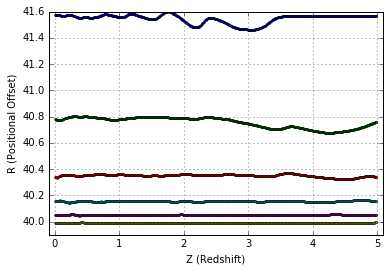

In [15]:
for Red in np.arange(0,5,0.01):
    testDcr = deepcopy(dcr);
    testDcr.redshiftSED(Red);
    U = [testDcr.calcR_DCR(testBandpassDict['u'],45.)];
    plt.plot(Red,U,'bo',markersize=2);
    G = [testDcr.calcR_DCR(testBandpassDict['g'],45.)];
    plt.plot(Red,G,'go',markersize=2);
    R = [testDcr.calcR_DCR(testBandpassDict['r'],45.)];
    plt.plot(Red,R,'ro',markersize=2);
    I = [testDcr.calcR_DCR(testBandpassDict['i'],45.)];
    plt.plot(Red,I,'co',markersize=2);
    z = [testDcr.calcR_DCR(testBandpassDict['z'],45.)];
    plt.plot(Red,z,'mo',markersize=2);
    Y = [testDcr.calcR_DCR(testBandpassDict['y'],45.)];
    plt.plot(Red,Y,'yo',markersize=2);

plt.ylabel('R (Positional Offset)')
plt.xlabel('Z (Redshift)')
plt.axis([-0.1, 5.1, 39.9, 41.6])

plt.grid()
plt.show()

In [15]:
U = np.zeros([50])
G = np.zeros([50])
R = np.zeros([50])
I = np.zeros([50])
z = np.zeros([50])
Y = np.zeros([50])

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


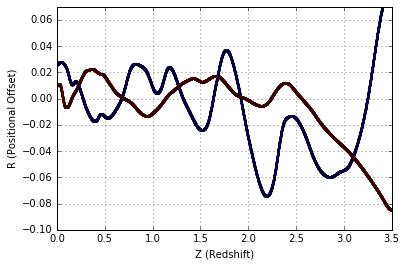

In [20]:
for Red in np.arange(0,5,0.001):
    testDcr = deepcopy(dcr);
    testDcr.redshiftSED(Red);
    U = [testDcr.calcR_DCR(testBandpassDict['u'],45.)];
    G = [testDcr.calcR_DCR(testBandpassDict['g'],45.)];
    R = [testDcr.calcR_DCR(testBandpassDict['r'],45.)];
    I = [testDcr.calcR_DCR(testBandpassDict['i'],45.)];
    z = [testDcr.calcR_DCR(testBandpassDict['z'],45.)];
    Y = [testDcr.calcR_DCR(testBandpassDict['y'],45.)];
    u_g = np.subtract(U,G);
    g_r = np.subtract(G,R);
    U_G = np.subtract(u_g,0.77)
    G_R = np.subtract(g_r,0.43)
    plt.plot(Red,U_G,'bo',markersize=2)
    plt.plot(Red,G_R,'ro',markersize=2)
plt.ylabel('R (Positional Offset)')
plt.xlabel('Z (Redshift)')
plt.axis([0, 3.5, -0.1, 0.07])

plt.grid()
plt.show()

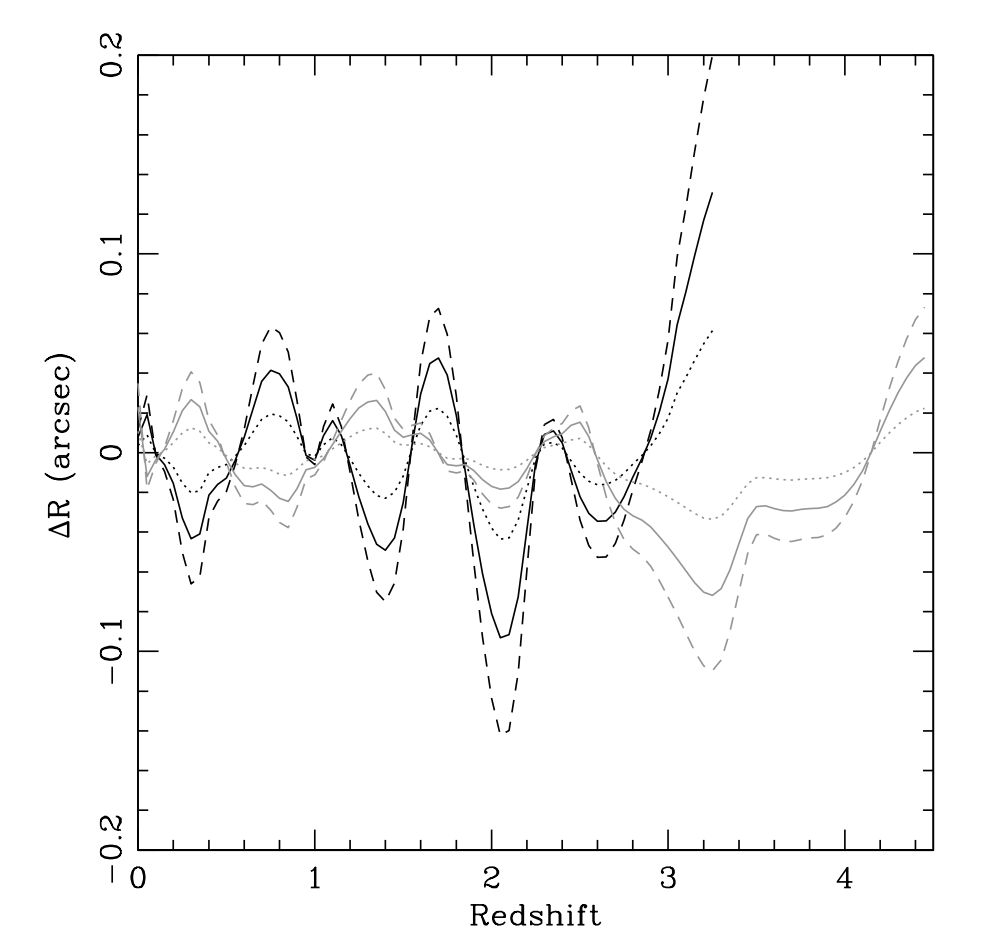

In [31]:
Image("DCR.png", width=500, height=500)
#Comparison Quasar